In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

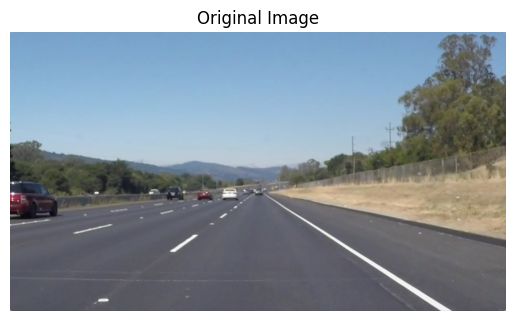

In [2]:
image = cv2.imread("test_images/solidWhiteRight.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

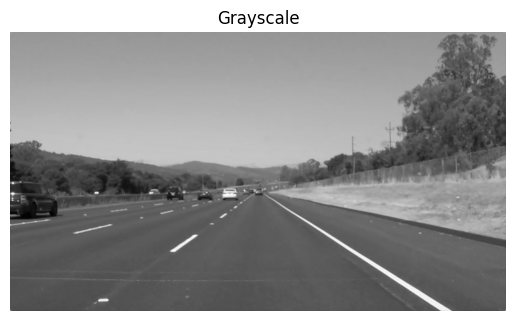

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

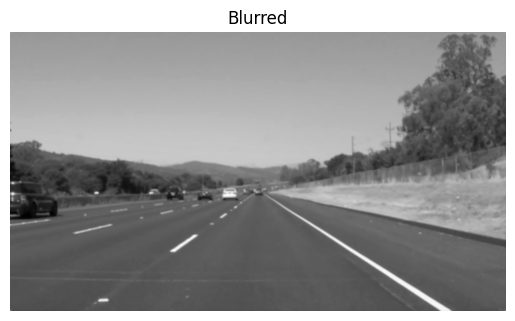

In [4]:
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blur, cmap="gray")
plt.title("Blurred")
plt.axis("off")

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

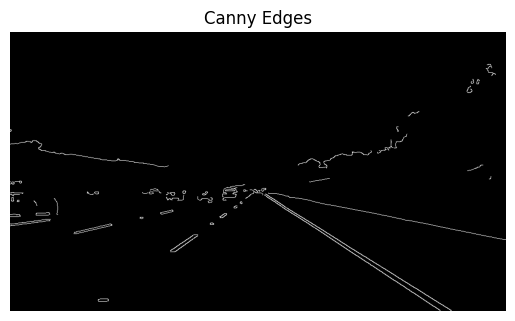

In [5]:
edges = cv2.Canny(blur, 100, 200)

plt.imshow(edges, cmap="gray")
plt.title("Canny Edges")
plt.axis("off")

In [6]:
def region_of_interest(img):
    height, width = img.shape
    mask = np.zeros_like(img)

    polygon = np.array([[
        (0, height),
        (width, height),
        (width//2, height//2)
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

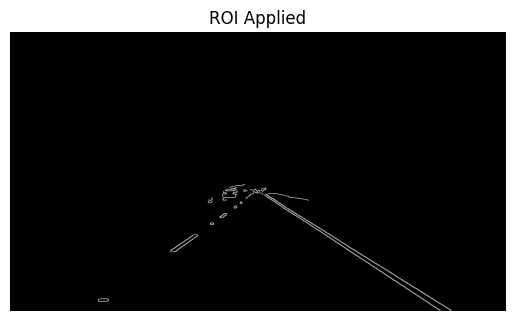

In [7]:
cropped = region_of_interest(edges)

plt.imshow(cropped, cmap="gray")
plt.title("ROI Applied")
plt.axis("off")

In [8]:
lines = cv2.HoughLinesP(
    cropped,
    2,
    np.pi/180,
    threshold=100,
    minLineLength=40,
    maxLineGap=5
)

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

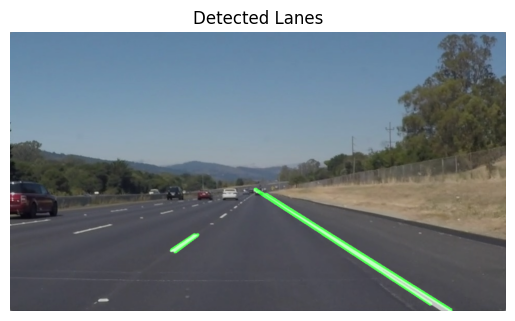

In [9]:
line_image = np.zeros_like(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 5)

final = cv2.addWeighted(image, 0.8, line_image, 1, 1)

plt.imshow(final)
plt.title("Detected Lanes")
plt.axis("off")

In [10]:
def lane_pipeline(image):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    cropped = region_of_interest(edges)

    lines = cv2.HoughLinesP(
        cropped,
        2,
        np.pi/180,
        100,
        minLineLength=40,
        maxLineGap=5
    )

    line_image = np.zeros_like(image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 5)

    final = cv2.addWeighted(image, 0.8, line_image, 1, 1)

    return final

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

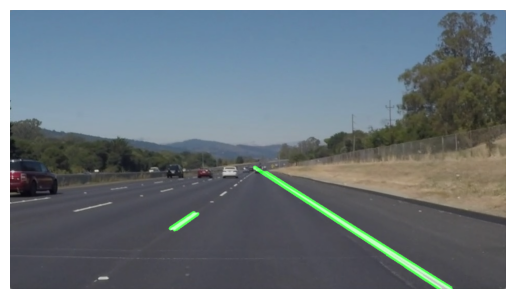

In [11]:
result = lane_pipeline(image)

plt.imshow(result)
plt.axis("off")

In [21]:
def detect_lanes(frame):

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 100, 200)

    cropped = region_of_interest(edges)

    lines = cv2.HoughLinesP(
        cropped,
        2,
        np.pi/180,
        100,
        minLineLength=40,
        maxLineGap=5
    )

    line_image = np.zeros_like(image)

    left_lines = []
    right_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = (y2 - y1) / (x2 - x1 + 1e-6)

            if abs(slope) < 0.5:
                continue

            if slope < 0:
                left_lines.append((x1, y1, x2, y2))
            else:
                right_lines.append((x1, y1, x2, y2))

    def draw_avg_line(lines):
        if len(lines) == 0:
            return
        
        x_coords = []
        y_coords = []

        for x1, y1, x2, y2 in lines:
            x_coords.extend([x1, x2])
            y_coords.extend([y1, y2])

        slope, intercept = np.polyfit(x_coords, y_coords, 1)

        y1 = image.shape[0]
        y2 = int(image.shape[0] * 0.6)

        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)

        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 8)

    draw_avg_line(left_lines)
    draw_avg_line(right_lines)

    final = cv2.addWeighted(image, 0.8, line_image, 1, 1)

    return cv2.cvtColor(final, cv2.COLOR_RGB2BGR)

In [22]:
def process_frame(frame):

    # 1️⃣ Lane Detection
    lane_frame = detect_lanes(frame)

    # 2️⃣ Object Detection (YOLO)
    results = model(lane_frame)

    # 3️⃣ Draw bounding boxes
    annotated_frame = results[0].plot()

    return annotated_frame

In [19]:
from ultralytics import YOLO

In [20]:
model = YOLO("yolov8n.pt")   # lightweight model

In [23]:
def process_frame(frame):

    # 1️⃣ Lane Detection
    lane_frame = detect_lanes(frame)

    # 2️⃣ Object Detection (YOLO)
    results = model(lane_frame)

    # 3️⃣ Draw bounding boxes
    annotated_frame = results[0].plot()

    return annotated_frame

In [24]:
cap = cv2.VideoCapture("test_videos/solidWhiteRight.mp4")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("final_output.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    processed = process_frame(frame)
    out.write(processed)

cap.release()
out.release()

print("Final combined video saved!")


0: 384x640 4 cars, 39.2ms
Speed: 7.6ms preprocess, 39.2ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 32.3ms
Speed: 6.5ms preprocess, 32.3ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 31.6ms
Speed: 7.0ms preprocess, 31.6ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 32.7ms
Speed: 4.8ms preprocess, 32.7ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 3 trucks, 31.7ms
Speed: 5.1ms preprocess, 31.7ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 3 trucks, 31.5ms
Speed: 5.2ms preprocess, 31.5ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 24.3ms
Speed: 5.3ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bench, 34.4ms
Speed: 4.4ms preprocess, 34.4ms inference, 5.5ms 